## Table of Contents

1. Load the MNIST dataset
2. Preprocess the dataset
3. Build and train a small neural network from scratch
4. Next steps

<hr>

# 1. Load the MNIST Dataset

In this section, you will download the zipped MNIST dataset files originally stored in <a href="http://yann.lecun.com/exdb/mnist/"> Yann LeCun's website</a>. Then, you will transform them into 4 files of NumPy array type using built-in Python modules. Finally, you will split the arrays into training and test sets.

1. Define a variable to store the training/test image/label names of the MNIST dataset in a list:

In [1]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

2. Load the data. First check if the data is stored locally; if not, then download it.

In [2]:
# Use responsibly! When running notebooks locally, be sure to keep local
# copies of the datasets to prevent unnecessary server requests
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw": "true"},
}

In [3]:
import requests
import os

data_dir = "../_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, **request_opts)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

3. Decompress the 4 files and create 4 `ndarrays`, saving them into a dictionary. Each original image is of size 28x28 and neural networks normally expect a 1D vector input; therefore you need to reshape the images by multiplying 28x28 (784).

In [4]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

4. Split the data into training and test sets using the standard notation of `x` for data and `y` for labels, calling the training and test set images `x_train` and `x_test`, and the labels `y_train` and `y_test`:

In [5]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

5. You can confirm that the shape of the image arrays is `(60000, 784)` and `(10000, 784)` for training and test sets, respectively, and the labels — `(60000,)` and `(10000,)`:

In [7]:
print("The shape of training images: {} and training labels: {}".format(x_train.shape, y_train.shape))
print("The shape of test images: {} and test labels: {}".format(x_test.shape, y_test.shape))

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


6. And you can inspect some images using Matplotlib:

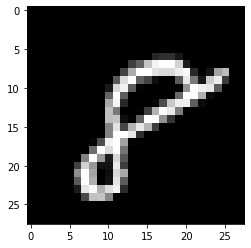

In [8]:
import matplotlib.pyplot as plt

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

In [11]:
# Display the label of the 60,000th image (indexed at 59,999) from the training set.
y_train[59999]

8

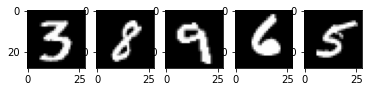

In [9]:
# Display 5 random images from the training set.
num_examples = 5
seed = 147197952744
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(x_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")

# 2. Preprocess the data

<hr>

Neural networks can work with inputs that are in a form of tensors (multidimensional arrays) of floating-point type. When preprocessing the data, you should consider the following processes: <a href="https://en.wikipedia.org/wiki/Vectorization_%28mathematics%29">vectorization</a> and <a href="https://en.wikipedia.org/wiki/Floating-point_arithmetic#Floating-point_numbers">conversion to a floating point format.</a>

Since the MNIST data is already vectorized and the arrays are of `dtype` `uint8`, your next challenge is to convert them to a floating-point format, such as `float64` (<a href="https://en.wikipedia.org/wiki/Double-precision_floating-point_format">double-precision</a>):

* _Normalizing_ the image data: a [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling#Application) procedure that can speed up the neural network training process by standardizing the [distribution of your input data](https://arxiv.org/pdf/1502.03167.pdf).
* _[One-hot/categorical encoding](https://en.wikipedia.org/wiki/One-hot)_ of the image labels.

In practice, you can use different types of floating-point precision depending on your goals and you can find more information about that in the [Nvidia](https://blogs.nvidia.com/blog/2019/11/15/whats-the-difference-between-single-double-multi-and-mixed-precision-computing/) and [Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/bfloat16-the-secret-to-high-performance-on-cloud-tpus) blog posts.

### Convert the image data to the floating-point format

The images data contain 8-bit integers encoded in the [0, 255] interval with color values between 0 and 255.

You will normalize them into floating-point arrays in the [0, 1] interval by dividing them by 255.

**1.** Check that the vectorized image data has type `uint8`:

In [12]:
print("The data type of training images: {}".format(x_train.dtype))
print("The data type of test images: {}".format(x_test.dtype))

The data type of training images: uint8
The data type of test images: uint8


**2.** Normalize the arrays by dividing them by 255 (and thus promoting the data type from `uint8` to `float64`) and then assign the train and test image data variables — `x_train` and `x_test` — to `training_images` and `train_labels`, respectively.
To reduce the model training and evaluation time in this example, only a subset
of the training and test images will be used.
Both `training_images` and `test_images` will contain only 1,000 samples each out
of the complete datasets of 60,000 and 10,000 images, respectively.
These values can be controlled by changing the  `training_sample` and
`test_sample` below, up to their maximum values of 60,000 and 10,000.

In [13]:
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

**3.** Confirm that the image data has changed to the floating-point format:

In [14]:
print("The data type of training images: {}".format(training_images.dtype))
print("The data type of test images: {}".format(test_images.dtype))

The data type of training images: float64
The data type of test images: float64


> **Note:** You can also check that normalization was successful by printing `training_images[0]` in a notebook cell. Your long output should contain an array of floating-point numbers:
>
> ```
> ...
>        0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
>        0.07058824, 0.49411765, 0.53333333, 0.68627451, 0.10196078,
>        0.65098039, 1.        , 0.96862745, 0.49803922, 0.        ,
> ...
> ```

### Convert the labels to floating point through categorical/one-hot encoding

You will use one-hot encoding to embed each digit label as an all-zero vector with `np.zeros()` and place `1` for a label index. As a result, your label data will be arrays with `1.0` (or `1.`) in the position of each image label.

Since there are 10 labels (from 0 to 9) in total, your arrays will look similar to this:


```
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
```


**1.** Confirm that the image label data are integers with `dtype` `uint8`:

In [15]:
print("The data type of training labels: {}".format(y_train.dtype))
print("The data type of test labels: {}".format(y_test.dtype))

The data type of training labels: uint8
The data type of test labels: uint8


**2.** Define a function that performs one-hot encoding on arrays:

In [16]:
def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

**3.** Encode the labels and assign the values to new variables:

In [17]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])


**4.** Check that the data type has changed to floating point:


In [18]:
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


**5.** Examine a few encoded labels:

In [19]:
print(training_labels[0])
print(training_labels[1])
print(training_labels[2])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


...and compare to the originals:


In [20]:
print(y_train[0])
print(y_train[1])
print(y_train[2])

5
0
4
